#### Importing Library

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import optuna
import matplotlib.pyplot as plt

#### Load and Preprocess Data

In [ ]:
# Using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load data
file_path = 'GOOG.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Filtering data till 2020 -> pre pandemic
data = data[data['Date'].dt.year <= 2020]

# Extracting target and train, test val dataset
values = data['Close'].values.astype('float32').reshape(-1, 1)
train_size = int(len(values) * 0.7)
val_size = int(len(values) * 0.15)
test_size = len(values) - train_size - val_size

train_data, val_data, test_data = np.split(values, [train_size, train_size + val_size])

# Scaling Data, fitting on Train Data
scaler = MinMaxScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data).flatten()
val_data_scaled = scaler.transform(val_data).flatten()
test_data_scaled = scaler.transform(test_data).flatten()


#### Dataset class

In [ ]:
# Defining  and calling the dataset for time series
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.sequence_length]
        y = self.data[idx + self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 30
train_dataset = TimeSeriesDataset(train_data_scaled, sequence_length)
val_dataset = TimeSeriesDataset(val_data_scaled, sequence_length)
test_dataset = TimeSeriesDataset(test_data_scaled, sequence_length)

#### Defining Model

In [ ]:
# Attention-based LSTM Model
class AttentionLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AttentionLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Attention layers
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x) 

        #attention score = v(tanh(W * out))
        attn_weights = self.v(torch.tanh(self.attn(out))).squeeze(-1)  #
        attn_weights = torch.softmax(attn_weights, dim=1) 

        attn_weights = attn_weights.unsqueeze(-1) 
        context = (out * attn_weights).sum(dim=1)  

        prediction = self.fc(context) 
        return prediction

#### Trainning Evaluation 

In [ ]:
# Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    train_loss_list, val_loss_list = [], []
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x = x.unsqueeze(-1).to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.unsqueeze(-1).to(device)
                y_val = y_val.to(device)
                val_output = model(x_val)
                val_loss = criterion(val_output.squeeze(), y_val)
                running_val_loss += val_loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_loss_list.append(val_loss)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return train_loss_list, val_loss_list

def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.unsqueeze(-1).to(device)
            y_test = y_test.to(device)
            output = model(x_test)
            predictions.extend(output.squeeze().cpu().tolist()) 
            targets.extend(y_test.cpu().tolist())

    # Inverse transform predictions and targets to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)

    return mse, mae, rmse, r2, predictions, targets

Using device: cuda


#### Hyper-parameter Optimization

In [ ]:
# Optuna Optimization
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    model = AttentionLSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=15)
    return min(val_loss)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

best_params = study.best_params
print("Best parameters:", best_params)


[I 2024-12-06 16:27:53,078] A new study created in memory with name: no-name-95abafa6-d015-482f-8157-c2d2eba2160f
[I 2024-12-06 16:28:38,281] Trial 0 finished with value: 0.00043981024272569984 and parameters: {'hidden_size': 25, 'num_layers': 1, 'learning_rate': 0.005830705629859513, 'batch_size': 16}. Best is trial 0 with value: 0.00043981024272569984.


Early stopping at epoch 37


[I 2024-12-06 16:29:25,153] Trial 1 finished with value: 0.0005392015480442512 and parameters: {'hidden_size': 75, 'num_layers': 1, 'learning_rate': 0.0013959320692435064, 'batch_size': 32}. Best is trial 0 with value: 0.00043981024272569984.
[I 2024-12-06 16:29:52,241] Trial 2 finished with value: 0.0006026689399732277 and parameters: {'hidden_size': 126, 'num_layers': 2, 'learning_rate': 0.005791342130716825, 'batch_size': 64}. Best is trial 0 with value: 0.00043981024272569984.
[I 2024-12-06 16:30:35,280] Trial 3 finished with value: 0.0014298947292110441 and parameters: {'hidden_size': 114, 'num_layers': 1, 'learning_rate': 0.0005125417485442754, 'batch_size': 32}. Best is trial 0 with value: 0.00043981024272569984.
[I 2024-12-06 16:31:09,019] Trial 4 finished with value: 0.0012880465656053275 and parameters: {'hidden_size': 113, 'num_layers': 1, 'learning_rate': 0.001600238117889695, 'batch_size': 64}. Best is trial 0 with value: 0.00043981024272569984.
[I 2024-12-06 16:31:28,724]

Early stopping at epoch 35


[I 2024-12-06 16:33:16,955] Trial 8 finished with value: 0.00037820099303069964 and parameters: {'hidden_size': 87, 'num_layers': 2, 'learning_rate': 0.0016232475607194687, 'batch_size': 32}. Best is trial 7 with value: 0.00030430383589732257.
[I 2024-12-06 16:33:37,128] Trial 9 finished with value: 0.001408050674945116 and parameters: {'hidden_size': 105, 'num_layers': 3, 'learning_rate': 0.00048321736090511735, 'batch_size': 64}. Best is trial 7 with value: 0.00030430383589732257.
[I 2024-12-06 16:34:08,237] Trial 10 finished with value: 0.006077390330107379 and parameters: {'hidden_size': 44, 'num_layers': 2, 'learning_rate': 0.0001105109728929972, 'batch_size': 16}. Best is trial 7 with value: 0.00030430383589732257.


Early stopping at epoch 18


[I 2024-12-06 16:35:03,888] Trial 11 finished with value: 0.0006268410075249818 and parameters: {'hidden_size': 85, 'num_layers': 2, 'learning_rate': 0.003145945913740195, 'batch_size': 16}. Best is trial 7 with value: 0.00030430383589732257.


Early stopping at epoch 34


[I 2024-12-06 16:35:55,422] Trial 12 finished with value: 0.0006208841219336751 and parameters: {'hidden_size': 90, 'num_layers': 2, 'learning_rate': 0.009362284640218009, 'batch_size': 16}. Best is trial 7 with value: 0.00030430383589732257.


Early stopping at epoch 31


[I 2024-12-06 16:36:41,097] Trial 13 finished with value: 0.0014665133850557093 and parameters: {'hidden_size': 57, 'num_layers': 3, 'learning_rate': 0.002582408663114783, 'batch_size': 32}. Best is trial 7 with value: 0.00030430383589732257.
[I 2024-12-06 16:37:28,176] Trial 14 finished with value: 0.0028504963388274376 and parameters: {'hidden_size': 61, 'num_layers': 2, 'learning_rate': 0.00021655242893875402, 'batch_size': 32}. Best is trial 7 with value: 0.00030430383589732257.
[I 2024-12-06 16:38:56,381] Trial 15 finished with value: 0.000666498011579844 and parameters: {'hidden_size': 17, 'num_layers': 1, 'learning_rate': 0.0033031887183699437, 'batch_size': 16}. Best is trial 7 with value: 0.00030430383589732257.
[I 2024-12-06 16:40:01,292] Trial 16 finished with value: 0.0016575863601001155 and parameters: {'hidden_size': 92, 'num_layers': 3, 'learning_rate': 0.009158147767787167, 'batch_size': 16}. Best is trial 7 with value: 0.00030430383589732257.


Early stopping at epoch 32


[I 2024-12-06 16:41:11,450] Trial 17 finished with value: 0.0008683712627603917 and parameters: {'hidden_size': 74, 'num_layers': 2, 'learning_rate': 0.0004505212997252399, 'batch_size': 32}. Best is trial 7 with value: 0.00030430383589732257.
[I 2024-12-06 16:42:56,186] Trial 18 finished with value: 0.00030588053827208616 and parameters: {'hidden_size': 44, 'num_layers': 1, 'learning_rate': 0.004677283295943832, 'batch_size': 16}. Best is trial 7 with value: 0.00030430383589732257.
[I 2024-12-06 16:44:42,784] Trial 19 finished with value: 0.0003383891787568762 and parameters: {'hidden_size': 39, 'num_layers': 1, 'learning_rate': 0.004272560756619074, 'batch_size': 16}. Best is trial 7 with value: 0.00030430383589732257.
[I 2024-12-06 16:46:39,308] Trial 20 finished with value: 0.00039030569157173003 and parameters: {'hidden_size': 28, 'num_layers': 1, 'learning_rate': 0.0060438067125141316, 'batch_size': 16}. Best is trial 7 with value: 0.00030430383589732257.


Early stopping at epoch 50


[I 2024-12-06 16:47:36,282] Trial 21 finished with value: 0.00030160040999337954 and parameters: {'hidden_size': 45, 'num_layers': 1, 'learning_rate': 0.004406251618938239, 'batch_size': 16}. Best is trial 21 with value: 0.00030160040999337954.


Early stopping at epoch 38


[I 2024-12-06 16:49:04,952] Trial 22 finished with value: 0.00040289927474569177 and parameters: {'hidden_size': 47, 'num_layers': 1, 'learning_rate': 0.0097367311752254, 'batch_size': 16}. Best is trial 21 with value: 0.00030160040999337954.


Early stopping at epoch 43


[I 2024-12-06 16:50:44,602] Trial 23 finished with value: 0.00034342215036992237 and parameters: {'hidden_size': 50, 'num_layers': 1, 'learning_rate': 0.0022247198447249896, 'batch_size': 16}. Best is trial 21 with value: 0.00030160040999337954.


Early stopping at epoch 48


[I 2024-12-06 16:52:16,391] Trial 24 finished with value: 0.0003719607221019278 and parameters: {'hidden_size': 30, 'num_layers': 1, 'learning_rate': 0.005059585993435797, 'batch_size': 16}. Best is trial 21 with value: 0.00030160040999337954.


Best parameters: {'hidden_size': 45, 'num_layers': 1, 'learning_rate': 0.004406251618938239, 'batch_size': 16}


#### Training the model with Best-Parameters

Early stopping at epoch 37
MSE: 7.2091, MAE: 2.0582, RMSE: 2.6850, R²: 0.9313


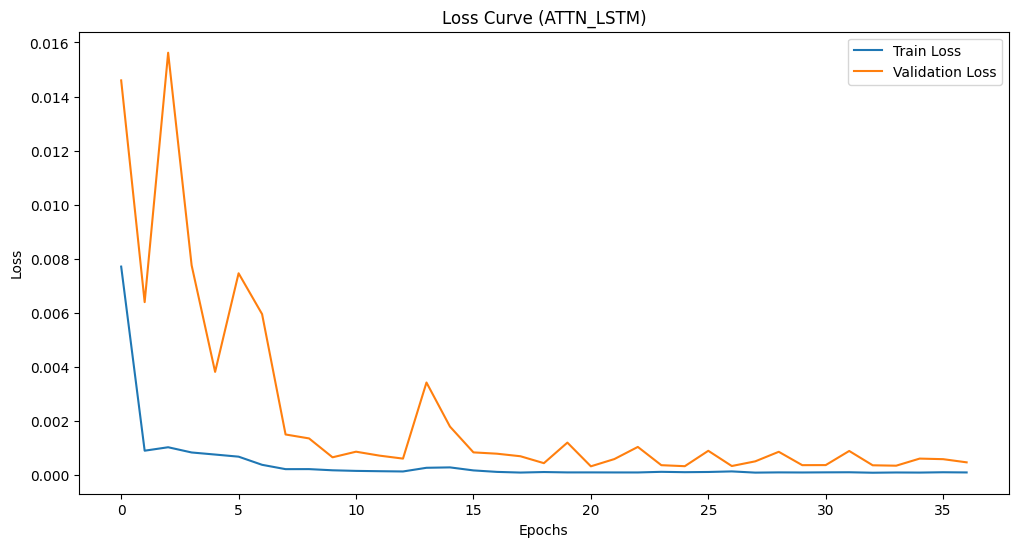

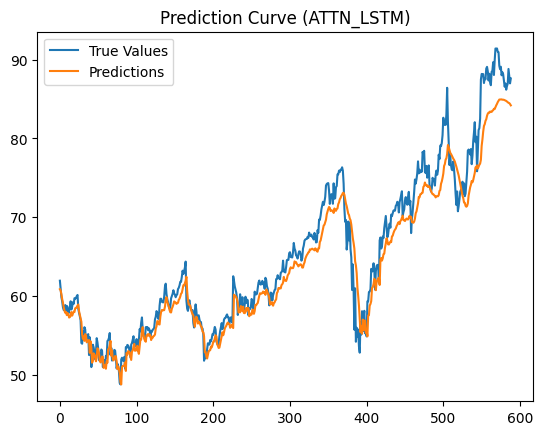

In [ ]:
# Final Training with Best Parameters

final_model = AttentionLSTMModel(input_size=1, hidden_size=best_params["hidden_size"], num_layers=best_params["num_layers"]).to(device)
model_type="ATTN_LSTM"
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])

final_batch_size = best_params["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=final_batch_size)
test_loader = DataLoader(test_dataset, batch_size=final_batch_size)

train_loss, val_loss = train_model(final_model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=15)

mse, mae, rmse, r2, predictions, targets = evaluate_model(final_model, test_loader)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title(f"Loss Curve ({model_type})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot predictions vs targets
plt.figure()
plt.plot(targets, label='True Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title(f"Prediction Curve ({model_type})")
plt.show()
